# Imports


## Install pydicom

In [1]:
# #pydicom trata as imagens em formatos DCM, que é tipo de arquivo das imagens 
# !pip install pydicom

## Import all libraries

In [2]:
# For files e data manipulations
import pandas as pd     
import os                
import zipfile                
import shutil            
import glob  
import gdown            

#For math operations           
import time               
import random               
import math                
import numpy as np 

#For plot
from matplotlib import pyplot     
import matplotlib.pyplot as plt  

#For images operations
import cv2             
import pydicom          
# from google.colab.patches import cv2_imshow    
from PIL import Image     
from numpy import expand_dims  
from scipy.io import loadmat 

#For Data augumentation  
import keras
import scipy
import tensorflow as tf          
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-01-07 09:20:32.362839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 09:20:32.584401: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lessinha/X-rayBodyPart/lessinha/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-07 09:20:32.584481: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-07 09:20:33.849441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

Eliminating warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Functions for downloads

In [4]:
def download(id: str) -> None:      #Download files by link GoogleDrive
    url = 'https://drive.google.com/uc?id=' + str(id)
    gdown.download(url, output = None, quiet = False)

def unzip(path: str) -> None:     #Unzip files .zip
    zip = zipfile.ZipFile(path)
    zip.extractall()
    zip.close()

## Root path

In [5]:
#If running in colab root_path = '/content/'
root_path = ''

In [6]:
# https://drive.google.com/file/d/1ev-r31j8oRzDlKM_toaeADO2psrA_XXm/view?usp=sharing

if os.path.isfile(f'{root_path}archive.zip'):
    print('The file exists.')
    unzip(f'{root_path}archive.zip')    

else:
    download('1ev-r31j8oRzDlKM_toaeADO2psrA_XXm')
    unzip(f'{root_path}archive.zip')    


The file exists.


In [7]:
# os.chdir(f'{root_path}/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
path = os.getcwd() 
train_df = pd.read_csv(f'{root_path}train.csv')
test_df = pd.read_csv(os.path.join(f'{root_path}sample_submission.csv'))

In [8]:
test_df.head(5)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


# Check pre-processing Data Frame

In [9]:
#Checks Pandas Dataset format and content properties
print("Columns:")
print(train_df.columns, "\n")

print("Types in columns:")
print(train_df.dtypes, "\n")

print("Types in info:")
print(train_df.describe(), "\n")

Columns:
Index(['SOPInstanceUID', 'Target'], dtype='object') 

Types in columns:
SOPInstanceUID    object
Target            object
dtype: object 

Types in info:
                                           SOPInstanceUID Target
count                                                1738   1738
unique                                               1738     41
top     1.2.826.0.1.3680043.8.498.10025629581362719970...     3 
freq                                                    1    724 



## Dictionary Bodyparts

The bodyparts code was taken of kaggle [The UNIFESP X-Ray Body Part](https://www.kaggle.com/datasets/felipekitamura/unifesp-xray-bodypart-classification)

In [10]:
bodyparts = {0 : 'Abdomen', 1 :'Ankle', 2 :'Cervical Spine', 3 : 'Chest', 4 :'Clavicles', 5 :'Elbow',
             6 :'Feet', 7 : 'Finger', 8 : 'Forearm', 9 : 'Hand', 10 : 'Hip',
            11 : 'Knee', 12 : 'Lower Leg', 13 : 'Lumbar Spine', 14 : 'Others', 15 :'Pelvis',
            16 :'Shoulder', 17 :'Sinus', 18 : 'Skull', 19 : 'Thigh', 20 :'Thoracic Spine', 21: 'Wrist'}

## Fixing folders

### Class ImageProcessing

In [11]:
class ImageProcessing():
  '''
    This class aims to prepare and organize the images, so she creates the masses for each label (organs),
    pre-processes the image for Data Augumentation and places it in its respective folder. Furthermore it puts all the images in a single folder as well.

    Attributes
      ----------
      file_List: 2D or 3D array
        

      Rotation_Range: int
          The limit value that the image can rotate.

      bright_range: list
          The threshold values of image brightness.

      folder: string
          Folder name of original images. They are divided into train and test

      new_Folder: string
          Name of the new folder that stays as pre-processed images.
        
  '''

  def __init__(self, folder: str, new_Folder: str) -> None:
    # self.file_List = []
    self.rotation_Range = 90 
    self.bright_Range = [0.2, 1.5]
    self.folder = folder                      #This is the folder of the original folder image
    self.new_Folder = new_Folder                #This is the new folder


  def create_folders(self) -> None:  
    '''
      This method creates folders for each label.
    '''
    os.mkdir(f'{root_path}{self.new_Folder}/') 
    for bodypart in list(bodyparts.values()):
      if os.path.isdir(f'{root_path}{self.new_Folder}/{bodypart}') == False:
        os.mkdir(f'{root_path}{self.new_Folder}/{bodypart}')
      else:  
          pass       


  def pre_processing_image(self, dicom_image: pydicom.dicomdir.DicomDir) -> Image:
    '''
    Pre-process the image and return the pre-processed image.
    '''
    img = dicom_image.pixel_array                
    resized_img  = (np.maximum(img,0)/img.max())*255    #It is a important part. This organize and resized image.
    im = resized_img.astype(np.uint8)       #Put in 8 bits format
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))    #Equalizer bright
    clahe_img = clahe.apply(im)
    return Image.fromarray(clahe_img)
    

  def name_path_image(self, filename: str, df: pd.core.frame.DataFrame, flag: bool, dictionary: dict = {}):
    '''
    This function takes the image information and returns the correct name. 

    The parameter flag (bool) is because self.all_image2Folder doesnt need label variable   
    '''
    var = filename.split("/")               #Split the string path name
    var = var[-1]                           #Take the name of the image
    if flag:
      return True, var[:-6] 

    row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()  #Search the name in DataFrame. This part [:-6] is to remove -c.dcm of the name
    target = df['Target'].iloc[row[0]]      #Take the label key
    if len(target.strip()) > 2:             #Images with more than one label (Bodyparts) is ignored
      return False, False
    
    label = dictionary.get(int(target)) 
    return label, var[:-6]   


  def file_list_path(self):
    file_list = []
    for root, dirs, files in os.walk(f'{root_path}{str(self.folder)}'):
      for file in files:
        file_list.append(os.path.join(root,file))

    self.file_list = file_list


  def label_image2folder(self, df: pd.core.frame.DataFrame, dictionary: dict) -> None:    #Put each image in a label folder
    '''
    This method places each image in its respective label (organ).
    '''
    self.file_list_path()
    for filename in self.file_list:
      label, var = self.name_path_image(filename, df=df, dictionary=dictionary, flag = False)
      if label == False: continue

      dicom = pydicom.dcmread(filename)       #Read filename (image.dcm)
      image = self.pre_processing_image(dicom_image=dicom)
      image.save(os.path.join(f'{root_path}{self.new_Folder}', f'{label}', f'{var}.png'))    #Save image in .png


  def all_Images2Folder(self, df: pd.core.frame.DataFrame) -> None:
    '''
    Puts all images, from all labels, in a single folder.
    '''
    self.file_list_path()
    for filename in self.file_list:
      label, var = self.name_path_image(filename, df=df, flag=True)
      if label == False: continue
      dicom = pydicom.dcmread(filename)
      image = self.pre_processing_image(dicom_image=dicom)
      image.save(os.path.join(f'{root_path}{self.new_Folder}/', f'{var[:-6]}.png'))

    return None
 

#### Implementation

In [12]:
#Organize the test images folder
name_Folder_Test = "test_img"
processImageTest = ImageProcessing(folder='test', new_Folder = name_Folder_Test)

try:
  os.mkdir(f'{root_path}{name_Folder_Test}')
  processImageTest.all_Images2Folder(train_df)

except:
  shutil.rmtree(f'{root_path}{name_Folder_Test}/')
  os.mkdir(f'{root_path}{name_Folder_Test}')
  processImageTest.all_Images2Folder(train_df)

In [13]:
#Organize the train images folder
nameFolderTrain = "train_img"
processImageTrain = ImageProcessing(folder='train', new_Folder = nameFolderTrain)

try:
  processImageTrain.create_folders()
  #This "train" is the name of the original folder of the images
  processImageTrain.label_image2folder(train_df, bodyparts)
except:
  shutil.rmtree(f'{root_path}{nameFolderTrain}/')
  processImageTrain.create_folders()
  processImageTrain.label_image2folder(train_df, bodyparts)


## Data Augumentation

### Class DataAugumentation

In [14]:
class DataAugumentation(ImageProcessing):
  '''
  This class performs data augmentation of images.  
  '''

  def __init__(
      self, 
      folder: str, 
      new_folder: str, 
      folder_img: str
  ) -> None:

    super().__init__(folder, new_folder)
    self.folder_img = folder_img
    self.name_image = []


  def duplicate_images_name(self, name:list) -> str:
    '''
    This function is for cases that make augumentation of augumentation. For that reason
    this function change the name of image.
    '''
    dup = [x for i, x in enumerate(self.name_image) if i != self.name_image.index(x)] 


    #In case of duplicate, it is written in its name that it is a repetition and a case of random duplication
    if len(dup) > 0:
      equal_dup = "_repeted_" + str(random.randint(-9999,9999))
    else:
      equal_dup = ""
    return equal_dup


  def process_maximum_originals(self, real_qntd:int, qntd:int, folder:str) -> None:
    '''
    After generating the images with multiples of the original quantity, 
    it is up to this function to complete the required number 
    using as many original images as possible.
    '''
    for i in range(100):
      check = real_qntd + real_qntd*i
      if check > qntd: 
        break
      multiplier = i
      diff_mult = qntd - check
    #From each original image we will take x times to approximate the required
    exams = [x for x in os.listdir(f'{root_path}{self.folder_img}/{folder}') if x.find("copy") == -1 ]  
    self.augment(folder, exams, multiplier) #Here we take by lot the rest that escapes the multiple
    
    if diff_mult>0:
      exams = [x for x in os.listdir(f'{root_path}{self.folder_img}/{folder}') if x.find("copy") == -1 ]
      exams = random.choices(exams, k= diff_mult)
      self.augment(folder, exams, 1)

  def process_imgs(self, qntd: int = 100) -> None:
    '''
    This method manages the data augmentation process considering the number of images in each label.
    '''
    for folder in os.listdir(f'{root_path}{self.folder_img}'):
      real_qntd = len(os.listdir(f'{root_path}{self.folder_img}/{folder}')) #real_qntd is quantity of exact images
      diff = qntd - real_qntd
      if qntd > real_qntd: 
        if real_qntd >= diff:
          #exams  is a list of images path sorted
          exams = random.choices(os.listdir(f'{root_path}{self.folder_img}/{folder}'), k= diff)    
          self.augment(folder, exams, 1)
        else:
          self.process_maximum_originals(real_qntd=real_qntd, qntd=qntd, folder=folder)

  
      #If you have more original images than requested, we get rid of the excess images by drawing too            
      elif real_qntd > qntd:
        diff = (real_qntd-qntd)
        sorteados = glob.glob(f'{root_path}{self.folder_img}/{folder}/*')
        for s in random.sample(sorteados, diff):
          os.remove(s)


  def data_generator(self, original_name: str, folder:str) -> keras.preprocessing.image.NumpyArrayIterator:
    '''
    This function generator a imagem augumentated.
    '''
    img = load_img(f'{root_path}{self.folder_img}/{folder}/{original_name}')
    data = img_to_array(img)
    samples = expand_dims(data, 0)
    #Call ImageDataGenerator to change the image, for a new image with rotarion, brightness and flip
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=self.rotation_Range,
        brightness_range=self.bright_Range
    )
  
    image_gen = datagen.flow(samples, batch_size=1)
    return image_gen


  def augment_unit(
      self, 
      image_generator, 
      folder: str, 
      label_duplicate:str, 
      original_name: str, 
      cont_original: int, 
      cont_copy: int
  ) -> None:
    ''' 
    This function performs the data augumentation of just one image only.
    '''
    batch = image_generator.next()
    image = batch[0].astype('uint16')
    resized_img  = (np.maximum(image,0)/image.max())*255 
    im = Image.fromarray(resized_img.astype(np.uint8))
    im.save(f'{root_path}{self.folder_img}/{folder}/{original_name[:-4]}_{label_duplicate}_copy_{cont_original}_{cont_copy}.png')
  

  def augment(self, folder: str, exams: list, limit: int) -> None:
    '''
    folder = name I gave to the label folder (ex: skull)
    exams = list of image files for each label folder
    limit = amount of artificial images created from the original
    '''
    cont1 = -1
    for exam in exams: 
      self.name_image.append(exam)
      image_gen = self.data_generator(original_name=exam, folder=folder)
      cont1 =+ 1
      equal_dup = self.duplicate_images_name(self.name_image)
        
      for cont in range(limit):
        self.augment_unit(
          image_generator = image_gen, folder=folder, 
          label_duplicate=equal_dup, original_name=exam, 
          cont_original=cont1, cont_copy=cont
        )


#### Implementation

In [15]:
#Augumented for Train image
AugumentedTrain  =  DataAugumentation(folder='train', new_folder = nameFolderTrain, folder_img = "train_img")
qntd_for_model = 100
AugumentedTrain.process_imgs(qntd=qntd_for_model) 

## Check images in folder

In [16]:
flag = False
for files in os.listdir(f'{root_path}train_img'):
  qntd_images_real = len(os.listdir(f'{root_path}train_img/{files}'))
  if qntd_images_real < qntd_for_model:
    print(f'The label {files} has less than {qntd_for_model} images.')
  else:
    flag=True
print(f'All label has exactly than {qntd_for_model} images.')

All label has exactly than 100 images.


In [17]:
for files in os.listdir(f'{root_path}train_img'):
  print(files)
  print(len(os.listdir(f'{root_path}train_img/{files}')))

Hip
100
Hand
100
Wrist
100
Ankle
100
Chest
100
Sinus
100
Feet
100
Thoracic Spine
100
Pelvis
100
Knee
100
Clavicles
100
Elbow
100
Finger
100
Abdomen
100
Thigh
100
Shoulder
100
Skull
100
Cervical Spine
100
Others
100
Lower Leg
100
Lumbar Spine
100
Forearm
100


## Select Folders for model

### Separating folder for train and validation

In [18]:
def folder_train_val(main_path, folder_model_label, qntd , bodyparts, flag): 
    '''
    Create folder for the model with specific amount of images (qntd)
    '''
    try:
        os.mkdir(f"{root_path}{folder_model_label}")
    except:
        shutil.rmtree(f"{root_path}{folder_model_label}")
        os.mkdir(f"{root_path}{folder_model_label}")

    #For each label in text format it is checked if a folder already exists
    for part in list(bodyparts.values()):
        if os.path.isdir(f"{root_path}{folder_model_label}/{part}") == False:
            os.mkdir(f"{root_path}{folder_model_label}/{part}")
        #Select 'x' images from a label folder and copy it to imageModel  
        # selectImages = random.choices(os.listdir(f'{main_path}/{part}'), k= qntd)
        selectImages = os.listdir(f'{main_path}/{part}')
        if flag == 'train':
            for image in selectImages[:qntd]:
                pathImageModel = f"{root_path}{folder_model_label}/{part}/{image}"
                originalPathImages = f'{main_path}/{part}/{image}'
                shutil.copy(originalPathImages, pathImageModel)
        elif flag == 'validation':
            for image in selectImages[qntd_for_model-qntd:]:
                pathImageModel = f"{root_path}{folder_model_label}/{part}/{image}"
                originalPathImages = f'{main_path}/{part}/{image}'
                shutil.copy(originalPathImages, pathImageModel)

#### Train

In [19]:
folder_model_label = "train_model"
main_path = f'{root_path}train_img'
qntd_train = 80
folder_train_val(main_path, folder_model_label, qntd_train, bodyparts, flag='train')

In [20]:
flag = False
for files in os.listdir(f'{root_path}train_model'):
  qntd_images_real = len(os.listdir(f'{root_path}train_model/{files}'))
  if qntd_images_real < qntd_train:
    print(f'The label {files} has {qntd_images_real} images.')
  else:
    flag=True

if flag:
  print(f'All label has exactly than {qntd_train} images.')

All label has exactly than 80 images.


#### Validation

In [21]:
folder_model_label = "val_model"
main_path = f'{root_path}train_img'
qntd_val = 20
folder_train_val(main_path, folder_model_label, qntd_val, bodyparts, flag='validation')

In [22]:
flag = False
for files in os.listdir(f'{root_path}val_model'):
  qntd_images_real = len(os.listdir(f'{root_path}val_model/{files}'))
  if qntd_images_real != qntd_val:
    print(f'The label {files} has {qntd_images_real} images.')
  else:
    flag=True

    
if flag:
  print(f'All label has exactly than {qntd_val} images.')

All label has exactly than 20 images.


# Model

In [23]:
#Select size
batch_size = 32  
img_height = 180 
img_width = 180

train_dir = f'{root_path}train_model'
val_dir = f'{root_path}val_model'

In [24]:
# Build a tensorflow dataset to be placed in the Keras library model
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2, #Part destined for a validation dataset
  subset="training",
  seed=123, 
  image_size=(img_height, img_width), #"shape" of file
  batch_size=batch_size)


Found 1760 files belonging to 22 classes.
Using 1408 files for training.


2023-01-07 09:22:02.734256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lessinha/X-rayBodyPart/lessinha/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-07 09:22:02.734324: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 09:22:02.734358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-T36DJFM): /proc/driver/nvidia/version does not exist
2023-01-07 09:22:02.734904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with

In [25]:
# Build a tensorflow dataset to be placed in the Keras library model
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 22 classes.
Using 88 files for validation.


## Visualization of images

In [26]:
class_names = train_ds.class_names
print(class_names)

['Abdomen', 'Ankle', 'Cervical Spine', 'Chest', 'Clavicles', 'Elbow', 'Feet', 'Finger', 'Forearm', 'Hand', 'Hip', 'Knee', 'Lower Leg', 'Lumbar Spine', 'Others', 'Pelvis', 'Shoulder', 'Sinus', 'Skull', 'Thigh', 'Thoracic Spine', 'Wrist']


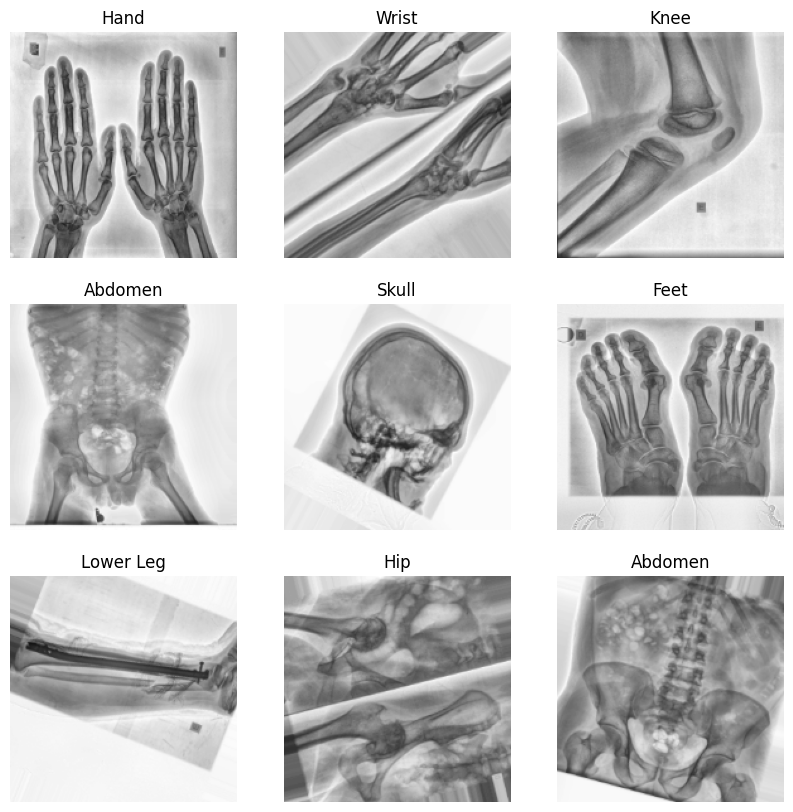

In [27]:
import matplotlib.pyplot as plt

#print first images (first batch) of the generator
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
#Checking "shape" - or format
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [29]:
#Checking "shape" - or format
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Implementing Model

In [30]:
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
# from tensorflow.keras.applications.inception_v3 import InceptionV3

### Transfer Learning choosen

In [31]:
from tensorflow.keras.applications import vgg16

In [32]:

def plot_history(history: keras.callbacks.History) -> None:
  '''
  This role belongs to Matheus Vieira, current Project Director at IEEE-CIS. 
  Not only did he help us with this project, he also contributed a lot of ideas. 
  We leave here our thanks to him.
  
  The purpose of this function is to trace the learning line of the neural network, 
  plotting the training and validation loss.
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

#### Random Seed

In [33]:
import random
random.seed(23)

In [34]:
# vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(input_shape = (img_width, img_height, 3), 
                       include_top = False, 
                       weights = 'imagenet')

# vgg.summary()
# Layer of transfer learning not trainable
# vgg.trainable = False
for layer in vgg.layers:
  layer.trainable = False
  
output = vgg.output
# three hidden layers
# output = keras.layers.GlobalAveragePooling2D()(output)
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(512, activation='relu')(output)
output = keras.layers.Dropout(0.75)(output) 
output = BatchNormalization()(output)
output = keras.layers.Dropout(0.5)(output) 
# output = keras.layers.Dense(22, activation='relu')(output)
# final softmax layer

predictions = keras.layers.Dense(len(bodyparts), activation='softmax')(output)

# creating the full model:
full_model = keras.models.Model(inputs=vgg.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [35]:
full_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [36]:
! mkdir model

mkdir: cannot create directory ‘model’: File exists


In [37]:
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model/model_vgg_{qntd_for_model}_1.h5', 
                                                verbose = 1, 
                                                save_best = True, 
                                                save_weights_only = True)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4) 


In [39]:
history = full_model.fit(train_ds, 
                        epochs=50,
                        validation_data=val_ds,
                        workers=5,
                        callbacks = [checkpoint, early_stop])

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 2.8816 - accuracy: 0.2266
Epoch 1: saving model to model/model_vgg_100_1.h5
44/44 [==============================] - 269s 6s/step - loss: 2.8816 - accuracy: 0.2266 - val_loss: 1.1576 - val_accuracy: 0.6705
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 1.8026 - accuracy: 0.4624
Epoch 2: saving model to model/model_vgg_100_1.h5
44/44 [==============================] - 265s 6s/step - loss: 1.8026 - accuracy: 0.4624 - val_loss: 0.9000 - val_accuracy: 0.8068
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.4996 - accuracy: 0.5795
Epoch 3: saving model to model/model_vgg_100_1.h5
44/44 [==============================] - 295s 7s/step - loss: 1.4996 - accuracy: 0.5795 - val_loss: 0.8254 - val_accuracy: 0.8068
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 1.2348 - accuracy: 0.6491
Epoch 4: saving model to model/model_vgg_100_1.h5
44/44 [===========================

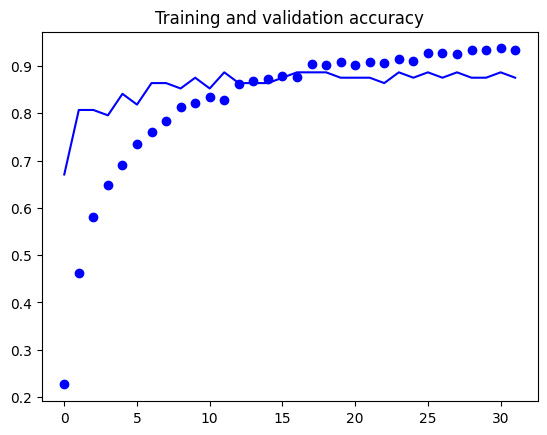

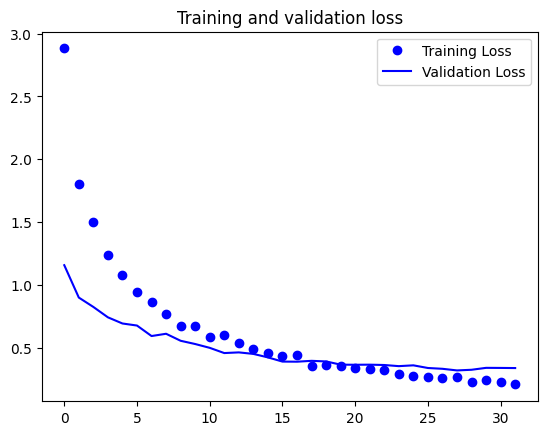

In [40]:
plot_history(history)